In [90]:
import numpy as np
import pandas as pd
import sympy
from operator import mul
from functools import reduce
from mpmath import fac
import functools
from sympy import init_printing
from IPython.display import display_latex
init_printing()

In [91]:
from sympy import Expr, Symbol, Eq, Mul, Add, Pow, expand, sympify, Tuple
from sympy.core.basic import Basic
from sympy.core.operations import AssocOp

from sympy.core.singleton import (Singleton, S)
from sympy.core.decorators import _sympifyit, call_highest_priority
from sympy.core.cache import cacheit

from sympy.core.function import diff
from sympy.series.order import Order


In [92]:
type(Expr.func)

property

In [87]:
class LieOperatorExpr(Expr):
    _op_priority = 12.0
    
    is_LieOperator = True
    is_Identity = False
    
    def __neg__(self):
        return DOMul(S.NegativeOne, self)
    
    def __abs__(self):
        raise NotImplementedError

    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__radd__')
    def __add__(self, other):
        return DOAdd(self, other)
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__add__')
    def __radd__(self, other):
        return DOAdd(other, self)
    
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rmul__')
    def __mul__(self, other):
        return DOMul(self, other)
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__mul__')
    def __rmul__(self, other):
        return DOMul(other, self)

    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rpow__')
    def __pow__(self, other):
        return DOPow(self, other)
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__pow__')
    def __rpow__(self, other):
        raise NotImplementedError("DiffOperator Power is not defined")
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__rdiv__')
    def __div__(self, other):
        return DOMul(self, other**S.NegativeOne)
    @_sympifyit('other', NotImplemented)
    @call_highest_priority('__div__')
    def __rdiv__(self, other):
        return DOMul(other, self**S.NegativeOne)

class LieOperatorOne(LieOperatorExpr):
    """
    Represents the identic operator ( DiffOperator**0).
    """

    __metaclass__ = Singleton

    is_Identity = True

class LieOperator(LieOperatorExpr):
    """
    >>> from sympy.abc import x, a
    >>> from sympy.core.function import Function
    >>> from sympy.tensor.diff_operator import DiffOperator
    >>> f = Function("f")

    >>> Lx = LieOperator(x)


    >>> Lx + Lx
    DiffOperator(x) + DiffOperator(x)

    >>> Lx(f(x))
    Derivative(f(x), x)

    >>> Dx + Dx**2
    DiffOperator(x) + DiffOperator(x)**2

    >>> (Dx + Dx**2)(f(x))
    Derivative(f(x), x) + Derivative(f(x), x, x)

    >>> (a*Dx + Dx**3)(x**4)
    4*a*x**3 + 24*x

    """
    def __new__(cls,ham, *coordmomenta):
        obj = LieOperatorExpr.__new__(cls,ham,*coordmomenta)
        obj._ham = obj._args[0]
        return obj

    @property
    def coords(self):
        return self._args[1:(len(self._args)+1)//2]
    
    @property
    def momenta(self):
        return self._args[(len(self._args)+1)//2:]
    
    @property
    def hamiltonian(self):
        return self._ham

    def _hashable_content(self):
        return tuple(sorted(self._args, key=hash))

    def __call__(self, e):
        terms = []
        for c,m in zip(self.coords, self.momenta):
            terms.append(Mul(diff(self.hamiltonian,c),diff(e,m)) -Mul(diff(self.hamiltonian,m),diff(e,c)))
        return reduce(Add,terms)

    def _eval_nseries(self, x, n, logx):
        return self + Order(n)

    def _latex(self, p):
        return "e^{:%s:}" % self.hamiltonian.func
#         rep = []

#         for c,m in zip(self.coords,self.momenta):
#             str1 = "\\frac{\partial %s}{\partial %s}  \\frac{\partial }{\partial %s}" % (p._print(self.hamiltonian),p._print(c),p._print(m))
#             str2 = "\\frac{\partial %s}{\partial %s}  \\frac{\partial }{\partial %s}" % (p._print(self.hamiltonian),p._print(m),p._print(c))
#             rep.append(str1 + ' - ' + str2)
#         return ' + '.join(rep)
        

    def _needs_brackets(self):
        return False

class DOAdd(LieOperatorExpr, Add):
    """
    A Sum of the LieOperator expressions.
    """

    def __new__(cls, *args):

        expr = Add.__new__(cls, *args)

        if expr.is_Mul:
            return DOMul(*expr.args)
        return expr

    def __call__(self, e):
        return Add(*tuple(d(e) for d in self.args))


    @classmethod
    def flatten(cls, args):
        new_seq = []
        i = 0
        while args:
            o = args.pop()
            if o.__class__ is cls:
                args.extend(o.args)
            else:
                new_seq.append(o)
        new_seq.reverse()
        return new_seq, [], None
    
    
    
class DOMul(LieOperatorExpr, Mul):
    def __new__(cls, *args):
        if any(arg.is_zero for arg in args):
            return S.Zero

        expr = Mul.__new__(cls, *args)
        print(args)
        return expr

    # is it needed?
    @classmethod
    def flatten(cls, args_seq):
        return args_seq, [], None

    def as_ordered_terms(self, order=None):
        return self.args

    @property
    def coords(self):
        c = ()
        for d in self.args:
            c += d.coords
        return tuple(set(c))
    
    @property
    def momenta(self):
        m = ()
        for d in self.args:
            m += d.momenta
        return tuple(set(m))
    
    def p(self,n):
        F = sympy.Matrix(np.zeros((n+1,n+1)))
        for i in range(n+1):
            for j in range(n+1):
                if (j-i)>=0:
        #             F[i,j] = 1/(np.math.factorial(j-i))
                    F[i,j] = sympy.Rational(1,int(fac(j-i))) # keep it rational !!!!

        G = sympy.Matrix(np.zeros((n+1,n+1)))
        for i in range(n+1):
            for j in range(n+1):
                if (j-i)>=0:
                    if i==j:
                        sigprod = 1
                    else:
                        l = sympy.symbols('s{}:{}'.format(i,j))
                        sigprod = reduce(sympy.Mul,l)
                    G[i,j] = sympy.Mul(sympy.Rational(1,int(np.math.factorial(j-i))),sigprod, evaluate=False)

        qthpower = sympy.Matrix(np.eye(n+1))
        FGm1 = sympy.nsimplify(F*G - qthpower)

        summ = []

        for q in range(1,n+1):
            qthpower = sympy.nsimplify(sympy.MatMul(qthpower, FGm1, evaluate=False))

            summ.append(sympy.nsimplify((-1)**(q-1)/q * qthpower)[0,n]) # q-1 because mathematica starts at 1 and not 0, there for sign change

        return sympy.expand(reduce(functools.partial(sympy.Add,evaluate=False),summ))
    
    def translated(self,n,ham1_symbol,ham2_symbol):
        l = sympy.symbols('s{}:{}'.format(0,n))
        temp = reduce(functools.partial(sympy.Mul,evaluate=False),[k*k for k in l])
        temp = sympy.expand(sympy.Mul(temp,  self.p(n), evaluate=False),evaluate=False)
        with sympy.evaluate(False):
            ln = sympy.symbols('r{}:{}'.format(0,n), commutative=False)
            for i, s in enumerate(l):
                temp = temp.subs(l[i],ln[i])
            for i in range(n):
                g = sympy.Symbol('g',commutative=False)
                f = sympy.Symbol('f',commutative=False)
                temp = temp.subs(ln[i]**3,g)
                temp = temp.subs(ln[i]**2,f)
        
        temp = temp.subs(f,ham1_symbol)
        temp = temp.subs(g,ham2_symbol)

        return temp
    
    def SumTranslated(self,n,ham1_symbol,ham2_symbol):
        return reduce(functools.partial(sympy.Add,evaluate=False),[self.translated(i,ham1_symbol,ham2_symbol) for i in range(1,n+1)])
    
    @property
    def hamiltonian(self):
        return self.SumTranslated(4,self.args[0].hamiltonian,self.args[1].hamiltonian).doit()

    
    
    def __call__(self, e):
        for e in self.args:
            print('ok')
        return e



In [88]:
x = Symbol('x')
px = Symbol('px')
y = Symbol('y')
py = Symbol('py')
f = sympy.Function('f',commutative=False)(x,px)
g = sympy.Function('g',commutative=False)(y,py)
H = sympy.Function('H',commutative=False)(x,px,y,py)
H1 = sympy.Function('H1',commutative=False)(x,px,y,py)
H2 = sympy.Function('H2',commutative=False)(x,px,y,py)
h = Symbol('h',commutative=False)
loe = LieOperator(H,x,y,px,py)
loe1 =LieOperator(H1,x,y,px,py)
loe2 =LieOperator(H2,x,y,px,py)

In [95]:
loe1+loe2

(LieOperator(H1(x, px, y, py), x, y, px, py), LieOperator(H2(x, px, y, py), x, y, px, py))


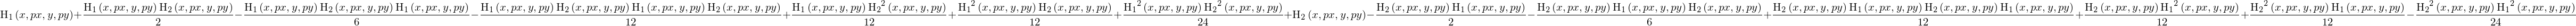

In [93]:
(loe1*loe2).hamiltonian

In [97]:
loe1*loe2

(LieOperator(H1(x, px, y, py), x, y, px, py), LieOperator(H2(x, px, y, py), x, y, px, py))


In [98]:
loe12mul = loe1*loe2

(LieOperator(H1(x, px, y, py), x, y, px, py), LieOperator(H2(x, px, y, py), x, y, px, py))


In [100]:
loe12mul(y)

ok
ok


In [32]:
Mul(loe1,loe2)

In [8]:
Mul(loe2,loe1)

In [564]:
Mul(loe1,loe2,2)
# (loe1*loe2).SumTranslated(3,loe1.hamiltonian,loe2.hamiltonian)

In [491]:
loe.coords

In [492]:
loe.momenta

In [493]:
loe.hamiltonian

In [494]:
loe

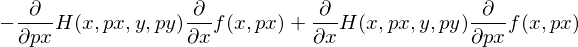

In [495]:
loe(f)

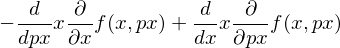

In [496]:
loe(f).subs(H,x)

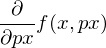

In [497]:
loe(f).subs(H,x).doit()

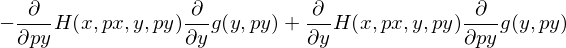

In [498]:
loe(g)

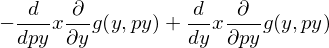

In [499]:
loe(g).subs(H,x)

In [500]:
loe(g).subs(H,x).doit()

In [501]:
loe12 = loe1+loe2
loe12

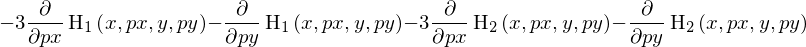

In [502]:
loe12(3*x+y)

In [451]:
loe12 = Mul(loe1,loe2)

In [453]:
loe12.doit()

In [448]:
loe12.hamiltonian

AttributeError: 'Mul' object has no attribute 'hamiltonian'